In [1]:
from __future__ import division
from dolfin import *
import math
import numpy as np


#!sudo pip2.7 install easydict
from easydict import EasyDict as edict

%matplotlib inline

In [2]:
print(has_linear_algebra_backend("PETSc"), has_linear_algebra_backend("Tpetra"))
print(has_krylov_solver_preconditioner("amg"), has_krylov_solver_method("minres"))

(True, False)
(True, True)


In [3]:
# =============================================================================
# CONSTANTS and PARAMETERS
# =============================================================================

ndp = edict({'U': 1.0,
 'asthenosphere': 0.0,
 'cohesion': 0.21023999999999998,
 'eta1': 1000.0000000000001,
 'eta2': 0.01,
 'fa': 0.4663076581549986,
 'g': 1.0,
 'rho': 1.3921567199999998})

In [4]:
# =============================================================================
# MESH
# =============================================================================

#width, height = 4, 1 # domain width and height
# option "crossed" stands for crossed diagonals (number of elements=XDIV*ZDIV*4)
mesh = RectangleMesh(Point(-2, 0), Point(2.0, 1.0), 32*4, 32, "crossed")
cell = triangle
norm = FacetNormal(mesh) # definition of an outer normal

ez = Constant((0, -1)) #gravity vector



In [5]:
coords = mesh.coordinates()
coords[0]

array([-2.,  0.])

In [6]:
# =============================================================================
# Define function spaces
# =============================================================================

# Taylor-Hood elements: linear Lagrange elements for pressure
# and quadratic Lagrange elements for velocity


V = VectorElement("Lagrange", mesh.ufl_cell(), 2)
P = FiniteElement("Lagrange", mesh.ufl_cell(), 1)

TH = V * P
W = FunctionSpace(mesh, TH)

In [7]:
# Define variational problem

(u , p) = TrialFunctions(W)



(v , q)= TestFunctions(W)



In [8]:
# =============================================================================
# INITIAL CONDITIONS - & Material distribution
# =============================================================================
u_init = Expression(("0", "0","0"), degree=2) # zero


density=Constant(ndp.rho)


tol = 1e-14

eta_1 = ndp.eta1
eta_2 = ndp.eta2

notchWidth = 1./16

#Fast but opaque C++ string, 
#eta = Expression('x[1] < 1./16 + tol && x[0] < 1./16 && x[0] > -1./16 ? eta_1 : eta_2', degree=0,
#               tol=tol, eta_1=eta_1, eta_2=eta_2)


class Eta(Expression):
    def set_eta_values(self, eta_1, eta_2):
        self.eta_1, self.eta_2 = eta_1, eta_2
    def eval(self, value, x):
        "Set value[0] to value at point x"
        tol = 1E-14
        if (x[1] < 1./16 + tol) and (x[0] <= 1./16 + tol ) and (x[0] >= -1./16 + tol ):
            value[0] = self.eta_2
        else:
            value[0] = self.eta_1
            
            
# Initialize Eta - viscosity
etaExpr = Eta(degree=1)
etaExpr.set_eta_values(ndp.eta1, eta_2)
etaExpr.eta_1, etaExpr.eta_2

(1000.0000000000001, 0.01)

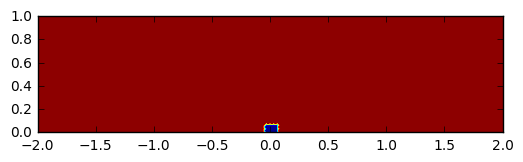

In [10]:
# =============================================================================
# Plotting expressions
# =============================================================================


X = FunctionSpace(mesh, P)

f = Function(X)
f.interpolate(etaExpr)
plot(f )

In [11]:
# =============================================================================
# BOUNDARY CONDITIONS
# =============================================================================

# Define boundaries
def left(x):
    return near(x[0], -2)

def right(x):
    return near(x[0], 2)


def bottom(x):
    return near(x[1], 0)

def top(x):
    return near(x[1], 1)




noslip = Constant((0, 0))
freeslip = Constant(0)
leftBC = Constant((1.0, 0))
rightBC = Constant((-1.0, 0))

#W.sub(1) ~ Pressure DoFs
#W.sub(0) ~ Vel DoFs


bc_v_bot = DirichletBC(W.sub(0).sub(1), freeslip, bottom)
bc_v_left = DirichletBC(W.sub(0), leftBC, left)
bc_v_right = DirichletBC(W.sub(0), rightBC,right)


# fixing the pressure at the top boundary

bc_p = DirichletBC(W.sub(1),
                    Expression("0", degree=1),
                    "near(x[0],0) && near(x[1],0)",
                    method="pointwise")


# collection of BCs for mechanical part of the problem
bcs_W = [bc_p, bc_v_bot, bc_v_left, bc_v_right]

In [12]:
# =============================================================================
# Rheology
# =============================================================================

def eijeij(u):
    """calculate second invariant of the strainrate tensor"""
    return sqrt(0.5*(inner(sym(nabla_grad(u)), sym(nabla_grad(u)))))

def viscosity(w):
    
    u, p = w.split()
    
    viscosityl = ndp.eta1
    viscosityp = 1e-10 + ndp.cohesion/(eijeij(u) + 1e-10)
    return 1./(1./etaExpr + 1./viscosityp)
 
    
#our viscosity function will return a Fenics /UFl Exprssion
#the expression must be projected to a finite element space before we can visualize it:    


#vtest = viscosity(u)    
V1 = FunctionSpace(mesh, 'P', 1)
#vtest = project(vtest, V1)
#plot(vtest, title='viscosity')
#print(type(vtest))

In [13]:
#Test a single solve

w = Function(W)


u_k = Function(W)
u_k.interpolate(u_init)



u_t = Function(W) #function to test different solutions

In [14]:
import numpy as np

w = Function(W)
u_k = Function(W)  
u_k.interpolate(u_init)
tol = 0.01
maxIts = 20

for i in range(maxIts):
    
    #a = 2.*viscosity(u_k)*inner(grad(v), grad(omega))*dx \
    #- p*div(omega)*dx \
    #+ div(v)*phi*dx
    
    a = nabla_div(u)*q*dx + p*nabla_div(v)*dx \
      - 2.*viscosity(w)*inner((nabla_grad(u)
      + transpose(nabla_grad(u))), transpose(nabla_grad(v)))*dx

    L = -1.*density*inner(ez, v)*dx

    solve(a == L, w, bcs_W)

    diff = w.vector().array() - u_k.vector().array()
    eps = np.linalg.norm(diff, ord=np.Inf)
    
    vL2 = np.linalg.norm(w.vector().array(), ord=np.Inf)
    eps2 = eps/vL2
    
    #Non linear residual?
    test = assemble(action(a, w) - L)
    test.array()
    res = np.linalg.norm(test.array(), ord=np.Inf)
    print (eps, eps2, res)

    u_k.assign(w)
    
    if eps2 < tol:
        break


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
(16179.023991326445, 1.0, 220.87166344423144)
(16176.196628112168, 4919.8794588725823, 0.059407762995320627)
(0.76994995470272887, 0.23623416236550843, 0.055278657135495603)
(0.22910979959394884, 0.070577737027757464, 0.053918795293597652)
(0.095951118914725964, 0.029568303703323261, 0.053350251448482537)
(0.0567115831206082, 0.01746325042841693, 0.052903039749283703)
(0.047006119067761531, 0.014461900703638644, 0.052575713650211318)
(0.039927625766057684, 0.01227555199500668, 0.052338834099872902)
(0.03579744903141413, 0.011000823888322048, 0.052152297773518347)
(0.032596369566629813, 0.010014944458226895, 0.052066753214068465)
(0.030011532058817458, 0.0092204977673664822, 0.051971471429063498)


In [15]:
# Combined Stokes, continuitycontinuity equation


#epsilon = 2*sym(grad(u))

#a = (viscosity(w)*inner(epsilon, grad(v)) \
#    - div(u)*q - div(v)*p)*dx


#L = density*inner(ez, v)*dx


#solve(a == L, w, bcs_W)


#u_k.assign(w)

In [16]:
# Split the mixed solution using deepcopy
# (needed for further computation on coefficient vector)
(u, p) = w.split(True)

print("Norm of velocity coefficient vector: %.15g" % u.vector().norm("l2"))
print("Norm of pressure coefficient vector: %.15g" % p.vector().norm("l2"))

Norm of velocity coefficient vector: 141.905006476453
Norm of pressure coefficient vector: 151.517979677393


In [334]:
u = w.split(deepcopy=True)[0]
ux, uy = u.split(deepcopy=True)
p = w.split(deepcopy=True)[1]


diff = p.vector().array()
eps = np.linalg.norm(diff, ord=np.Inf)
eps

3.2548711377638799

In [335]:
File('u.pvd') << u
File('p.pvd') << p


In [298]:
test = u 


V2 = FunctionSpace(mesh, 'P', 2)

#diffFEM = project(test , V2)

File('dp.pvd') << test

In [299]:
#Is this the non-linear residual?
#http://fenics.readthedocs.io/projects/ffc/en/latest/_modules/ffc/errorcontrol/errorcontrolgenerators.html
test = assemble(action(a, w) - L)
test.array()
np.linalg.norm(test.array(), ord=np.Inf)

            Calling FFC just-in-time (JIT) compiler, this may take some time.


110.43582051153517

In [22]:
# Define solution functions - current solution
w = Function(W)
u, p = split(w)


epsilon = 2*sym(grad(u))

F = (viscosity(w)*inner(epsilon, grad(v)) \
    - div(u)*q - div(v)*p)*dx \
    - density*inner(ez, v)*dx


J_W = derivative(F, w)
# create nonlinear problem
problem_W = NonlinearVariationalProblem(F, w, bcs_W, J_W)
solver_W = NonlinearVariationalSolver(problem_W)
prm_W = solver_W.parameters
# Newton solver parameters (mechanical part of the problem)
prm_W["newton_solver"]["relative_tolerance"] = 1E-7
#prm_W["newton_solver"]["absolute_tolerance"] = 1E-2
prm_W["newton_solver"]["maximum_iterations"] = 5
prm_W["newton_solver"]["relaxation_parameter"] = 1.0
#prm_W["newton_solver"]["convergence_criterion"] = 'incremental'
prm_W["newton_solver"]["convergence_criterion"] = "residual"

prm_W["newton_solver"]["linear_solver"] = "mumps"
set_log_level(PROGRESS)

In [23]:
# initializing velocity-pressure
w.interpolate(u_k)
u, p = w.split()
#info("Solve momentum equation")
solver_W.solve()

RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve nonlinear system with NewtonSolver.
*** Reason:  Newton solver did not converge because maximum number of iterations reached.
*** Where:   This error was encountered inside NewtonSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2016.2.0
*** Git changeset:  0f003bc07ee5fd583fb956245016d5972b80fea1
*** -------------------------------------------------------------------------


In [ ]:
#diff = u.vector().array() - u_k.vector().array()

In [70]:

u, p = w.split()

In [220]:
u0.vector().array().shape

(66178,)

In [221]:
u.vector().array().shape

(66178,)

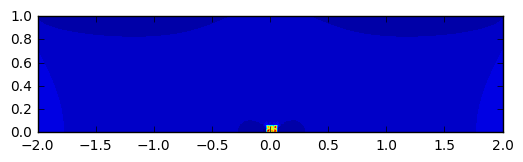

In [207]:
plot(p, scalarbar = True )



In [81]:
#plot(mesh, title="Finite element mesh")
plot(u - a,scale = 0.1)

TypeError: unsupported operand type(s) for +: 'Function' and 'Form'

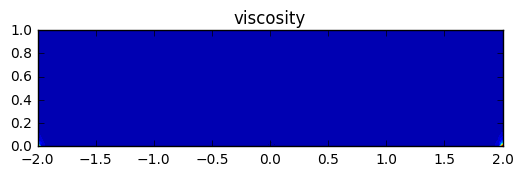

In [27]:
vtest = viscosity(u_k)  
V1 = FunctionSpace(mesh, 'P', 1)
vtest = project(vtest, V1)
plot(vtest, title='viscosity')

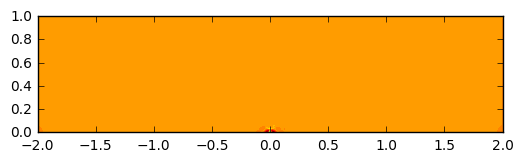

In [28]:
#Plot strain rate tensor components

W2 = TensorFunctionSpace(mesh, "Lagrange", 2)
sigma_w = project(sym(nabla_grad(u)), W2)

#sym(nabla_grad(v)
plot(sigma_w[0, 0], interactive=True) 

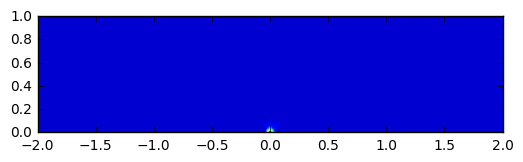

In [29]:
#Plot strain rate invariant components
#not we don't have to project this guy

eij =  sqrt(0.5*(inner(sym(nabla_grad(u)), sym(nabla_grad(u)))))
plot(eij , interactive=True, scalarbar = True ) 

In [29]:
#But we do need to project it to get it values at nodes
eijFEM = project(eij , V1)



In [177]:
from IPython.display import HTML

In [178]:
#HTML(X3DOM().html(v))

In [179]:
info(prm_W, True)

In [180]:
#bc.homogenize()
b = assemble(F_W)
#bc.apply(b)
print('residual: {0}'.format(b.norm('l2')))

residual: 0.616968884074


In [159]:
#bcs_W.homogenize()
b = assemble(F_W)
#bcs_W.apply(b)
print('residual: {0}'.format(b.norm('l2')))

residual: 0.618680716571


In [160]:
1.239e-01

0.1239

In [55]:
# Save solution to file
v, p = u_k.split()
File('v.pvd') << u
File('p.pvd') << p
File('mesh.pvd') << mesh

In [18]:
File('mesh.pvd') << mesh

In [30]:
File('eij.pvd') << eijFEM

In [266]:
help(plot)

Help on function plot in module dolfin.common.plotting:

plot(object, *args, **kwargs)
    Plot given object.
    
    *Arguments*
        object
            a :py:class:`Mesh <dolfin.cpp.Mesh>`, a :py:class:`MeshFunction
            <dolfin.cpp.MeshFunction>`, a :py:class:`Function
            <dolfin.functions.function.Function>`, a :py:class:`Expression`
            <dolfin.cpp.Expression>, a :py:class:`DirichletBC`
            <dolfin.cpp.DirichletBC>, a :py:class:`FiniteElement
            <ufl.FiniteElement>`, or a :py:class:`MultiMesh
            <dolfin.cpp.MultiMesh>`.
    
    *Examples of usage*
        In the simplest case, to plot only e.g. a mesh, simply use
    
        .. code-block:: python
    
            mesh = UnitSquare(4,4)
            plot(mesh)
    
        Use the ``title`` argument to specify title of the plot
    
        .. code-block:: python
    
            plot(mesh, tite="Finite element mesh")
    
        It is also possible to plot an element
    
  

In [47]:
#mesh.meshes.

In [125]:
uvals = eijFEM.vector().array()
xyvals = mesh.coordinates()
#xyvals = dofs_x
xvals = xyvals[:,0]
yvals= xyvals[:,1]

xx = np.linspace(-2,2, 100)
yy = np.linspace(0,1, 25)

XX, YY = np.meshgrid(xx,yy)


from scipy.interpolate import griddata
uu = griddata(np.column_stack((xvals, yvals)), uvals, np.dstack((XX, XX)))

uvals = eijFEM.vector().array()
xyvals = mesh.coordinates()
#xyvals = dofs_x
xvals = xyvals[:,0]
yvals= xyvals[:,1]

xx = np.linspace(-2,2, 100)
yy = np.linspace(0,1, 25)

XX, YY = np.meshgrid(xx,yy)


In [ ]:
# =============================================================================
# Picard iterations
# =============================================================================

import numpy as np

#u_k = interpolate(Constant(0.0, 0.0), V)  # previous (known) u
u = Function(W)
u_k = Function(W) ;
u_k.interpolate(u_init)
eps = 1.0           # error measure ||u-u_k||
tol = 1.0E-5        # tolerance
iter = 0            # iteration counter
maxiter = 2        # max no of iterations allowed
while eps > tol and iter < maxiter:
    
    a = 2.*viscosity(u_k)*inner(grad(v), grad(omega))*dx \
    - p*div(omega)*dx + div(v)*phi*dx
    
    L = density*inner(ez, omega)*dx
    #solve(a == L, u, bcs_W)

    u_k.assign(u)
    
    
    #diff = u.vector().array() - u_k.vector().array()
    #eps = numpy.linalg.norm(diff, ord=numpy.Inf)
    #print 'iter=%d: norm=%g' % (iter, eps)
    #u_k.assign(u)   # update for next iteration
    
